## Training pipeline (random-sample (no C) dataset)

This notebook contains all the code used to train the NN with the random-sample-noC dataset.

In [1]:
#from iml.utils.configuration_utils import run_dataset_generation_from_config, generate_water_from_config
#from iml.source.external_software import PhreeqcDatasetEngine
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as k
from tensorflow.keras import layers
import optuna
from datetime import datetime

[08:52:07] INFO     --------------------------------------

           INFO     Welcome to iML 0.11.1

           INFO     Submodule geochemistry loaded

           INFO     Submodule hydrogeology loaded

           INFO     --------------------------------------

[08:52:08] WARNING  Latin Hypercube Sampling is not available, please install LHS from pip install LHS

[08:52:30] WARNING  From                                                                                           
                    C:\Users\joaquim.tarin\Documents\dev\iml\iml\.venv\Lib\site-packages\keras\src\losses.py:2976: 
                    The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use                      
                    tf.compat.v1.losses.sparse_softmax_cross_entropy instead.                                      
           

### Dataset gathering

First the dataset is loaded:

In [2]:
'''
input_dataset = run_dataset_generation_from_config()
kin_batch_size = 2500

phreeqc_engine = PhreeqcDatasetEngine(
    nxyz=len(input_dataset),
    n_threads=18,
    input_dataset = input_dataset, chemical_setup = generate_water_from_config(),
    kin_batch_size=kin_batch_size
)
'''

{'Oseberg_water': {'general': {'porosity': {'range': [0.1, 0.1], 'log': False}, 'saturation': {'range': [1, 1], 'log': False}, 'Temperature': {'range': [100, 100], 'log': False}, 'Pressure': {'range': [276.34, 276.34], 'log': False}}, 'species': {'Ca': {'range': [0.00503, 0.019], 'log': False}, 'Si': {'range': [3.9e-05, 0.0042], 'log': False}, 'H': {'range': [2e-07, 0.039], 'log': False}, 'O': {'range': [1e-07, 0.039], 'log': 'FalseS'}}, 'minerals': {'Portlandite': {'range': [0.0, 0.89], 'log': False, 'composition': {'Ca': 1, 'H': 2, 'O': 2}, 'zero_proportion': 0.5}, 'Jennite': {'range': [0.0, 0.83], 'log': False, 'composition': {'Si': 1, 'Ca': 1.6667, 'O': 5.7667, 'H': 4.2}, 'zero_proportion': 0.4}}, 'punches': {'t_O_corrected': "PUNCH TOT('O')-1000/GFW('H2O')", 't_H_corrected': "PUNCH TOT('H')-2000/GFW('H2O')", 'density': 'PUNCH RHO', 'sol_vol': 'PUNCH SOLN_VOL', 'water_mass_fraction': "PUNCH TOT('water')/(RHO*SOLN_VOL)"}}, 'dataset_generation': {'number_of_samples': 100000, 'n_phree

[08:52:32] INFO     water Oseberg_water has been created

           INFO     Species Ca has been created with values range [0.00503, 0.019] mol/kgw

           INFO     Species Si has been created with values range [3.9e-05, 0.0042] mol/kgw

           INFO     Species H has been created with values range [2e-07, 0.039] mol/kgw

           INFO     Species O has been created with values range 10^[1e-07, 0.039] mol/kgw

           INFO     Mineral Portlandite has been created with values range [0.0, 0.89] mol/l med and composition   
                    {'Ca': 1, 'H': 2, 'O': 2}

           INFO     A 0.5 proportion of the dataset will have no  Portlandite

           INFO     Mineral Jennite has been created with values range [0.0, 0.83] mol/l med and composition {'Ca':
                    1.6667, 'H': 4.2, 'O': 5.7667, 'Si': 1}

           INFO     A 0.4 proportion of the dataset will have no  Jennite

Database generation pipeline:
  -> random_dataset_engine
     <Water Oseberg_water>:
       -> <Base porosity>
       -> <Base saturation>
       -> <Base Temperature>
       -> <Base Pressure>
       -> <Species Ca [0.00503, 0.019] mol/kgw>
       -> <Species Si [3.9e-05, 0.0042] mol/kgw>
       -> <Species H [2e-07, 0.039] mol/kgw>
       -> <Species O 10^[1e-07, 0.039] mol/kgw>
       -> <Mineral Portlandite [0.0, 0.89] mol/l med composition: {'Ca': 1, 'H': 2, 'O': 2}>
       -> <Mineral Jennite [0.0, 0.83] mol/l med composition: {'Ca': 1.6667, 'H': 4.2, 'O': 5.7667, 'Si': 1}>




           INFO     Running database creation pipeline

           INFO     Starting generation of random input_dataset with 100000 elements using Oseberg_water

[08:52:35] INFO     Dataset generation complete. A total of 100000 samples have been added.

           INFO     Database pipeline completed. Total number of generated samples: 100000. Call                   
                    DatasetGenerator.input_dataset to get the input_dataset

{'Oseberg_water': {'general': {'porosity': {'range': [0.1, 0.1], 'log': False}, 'saturation': {'range': [1, 1], 'log': False}, 'Temperature': {'range': [100, 100], 'log': False}, 'Pressure': {'range': [276.34, 276.34], 'log': False}}, 'species': {'Ca': {'range': [0.00503, 0.019], 'log': False}, 'Si': {'range': [3.9e-05, 0.0042], 'log': False}, 'H': {'range': [2e-07, 0.039], 'log': False}, 'O': {'range': [1e-07, 0.039], 'log': 'FalseS'}}, 'minerals': {'Portlandite': {'range': [0.0, 0.89], 'log': False, 'composition': {'Ca': 1, 'H': 2, 'O': 2}, 'zero_proportion': 0.5}, 'Jennite': {'range': [0.0, 0.83], 'log': False, 'composition': {'Si': 1, 'Ca': 1.6667, 'O': 5.7667, 'H': 4.2}, 'zero_proportion': 0.4}}, 'punches': {'t_O_corrected': "PUNCH TOT('O')-1000/GFW('H2O')", 't_H_corrected': "PUNCH TOT('H')-2000/GFW('H2O')", 'density': 'PUNCH RHO', 'sol_vol': 'PUNCH SOLN_VOL', 'water_mass_fraction': "PUNCH TOT('water')/(RHO*SOLN_VOL)"}, 'solid_solutions': {}, 'kinetic_solver': {}}, 'dataset_genera

           INFO     water Oseberg_water has been created

           INFO     Species Ca has been created with values range [0.00503, 0.019] mol/kgw

           INFO     Species Si has been created with values range [3.9e-05, 0.0042] mol/kgw

           INFO     Species H has been created with values range [2e-07, 0.039] mol/kgw

           INFO     Species O has been created with values range 10^[1e-07, 0.039] mol/kgw

           INFO     Mineral Portlandite has been created with values range [0.0, 0.89] mol/l med and composition   
                    {'Ca': 1, 'H': 2, 'O': 2}

           INFO     A 0.5 proportion of the dataset will have no  Portlandite

           INFO     Mineral Jennite has been created with values range [0.0, 0.83] mol/l med and composition {'Ca':
                    1.6667, 'H': 4.2, 'O': 5.7667, 'Si': 1}

           INFO     A 0.4 proportion of the dataset will have no  Jennite

           WARNING  Local database file was not provided, using default instead (located at                        
                    C:\Users\joaquim.tarin\Documents\dev\iml\iml\iml\config\phreeqc.dat)

In [3]:
'''
tic = time.time()
output_dataset = phreeqc_engine.run()
toc = time.time()
print(toc-tic)
'''

[08:53:04] INFO     Output dataset generation done

28.7711238861084


In [6]:
input_dataset = pd.read_csv('../datasets/random-sample-noC-input.csv')

In [7]:
output_dataset = pd.read_csv('../datasets/random-sample-noC-output.csv')

In [6]:
input_dataset['massOfWater'] = input_dataset['porosity']*input_dataset['saturation']
#input_dataset['Calcite'] = input_dataset['Cal']
input_dataset = input_dataset.drop(columns=['porosity','saturation'])
for var in ['Ca','Si','O','H']:
    input_dataset = input_dataset.rename(columns={var: var+'_tr'})
for min in ['Portlandite', 'Jennite']:
    input_dataset = input_dataset.rename(columns={min: 'k_'+min})
output_dataset.columns = output_dataset.columns.str.replace(r'(\w+)\(mol/kgw\)$', r't_\1', regex=True)
output_dataset.columns = output_dataset.columns.str.replace(r'^d_([A-Z])', r'dk_\1', regex=True)
output_dataset = output_dataset.rename(columns={'time': 'Time_Step', 'mass_H2O': 'water', 'density': 'density_coupling', 'water_mass_fraction': 'waterMassFraction_coupling'})
output_dataset = output_dataset.drop(columns=['step','dk_Portlandite','dk_Jennite'])#,'dk_Cal'])

In [7]:
output_dataset.columns

Index(['Time_Step', 'pH', 'pe', 'temp(C)', 'water', 't_Ca', 't_Si', 'Jennite',
       'Portlandite', 'si_Jennite', 'si_Portlandite', 't_O_corrected',
       't_H_corrected', 'density_coupling', 'sol_vol',
       'waterMassFraction_coupling', 'd_water(mol/l med)', 'timestep'],
      dtype='object')

In [8]:
input_dataset.columns

Index(['Temperature', 'Pressure', 'Ca_tr', 'Si_tr', 'H_tr', 'O_tr',
       'k_Portlandite', 'k_Jennite', 'massOfWater'],
      dtype='object')

In [9]:
input_dataset = input_dataset.drop(columns=['Temperature', 'Pressure'])
#output_dataset = output_dataset.drop(columns=['Time_Step', 'pe', 'pH', 'temp(C)', 'water', 'density_coupling',
#       'sol_vol', 'd_water(mol/l med)', 'timestep', 'si_Cal', 'si_Jennite', 'si_Portlandite'])
output_dataset = output_dataset.drop(columns=['Time_Step', 'pe', 'pH', 'temp(C)', 'water', 'density_coupling',
       'sol_vol', 'd_water(mol/l med)', 'timestep', 'si_Jennite', 'si_Portlandite'])

### Data rescaling

Log transform is performed on the aqueous phases. Then, MinMaxScaler is applied to all the data.

In [10]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

data = pd.DataFrame()
for col in input_dataset.columns:
    data[col] = input_dataset[col]
for col in output_dataset.columns:
    data[col] = output_dataset[col]    

for col in data:
    if '_tr' in col:
        data[col] = np.log(1e-10 + data[col])# - data[col].min())
    elif 't_' in col:
        data[col] = np.log(1e-10 + data[col])# - data[col].min())

scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data)

In [11]:
data.shape

(100000, 14)

In [12]:
data = pd.DataFrame(data, columns=['Ca_tr','Si_tr','H_tr','O_tr','Portlandite', 'Jennite', 'massOfWater',
    't_Ca','t_Si','t_H','t_O','k_Portlandite', 'k_Jennite', 'waterMassFraction_coupling'])
data.describe()

,Ca_tr,Si_tr,H_tr,O_tr,Portlandite,Jennite,massOfWater,t_Ca,t_Si,t_H,t_O,k_Portlandite,k_Jennite,waterMassFraction_coupling
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-0.847569,-0.633727,-0.291591,0.499761,0.250124,0.300801,1.0,-0.829169,-0.911046,0.300892,0.249838,0.384182,-0.779711,0.998732
std,0.069439,0.088255,0.068597,0.288825,0.322564,0.331345,0.0,0.066148,0.095474,0.331193,0.322256,0.257340,0.076575,0.000484
min,-1.000000,-1.000000,-1.000000,0.000018,0.000000,0.000000,1.0,-1.000000,-1.000000,0.000000,0.000000,-0.254293,-1.000000,0.997533
25%,-0.900648,-0.673591,-0.318486,0.250179,0.000000,0.000000,1.0,-0.854316,-0.965853,0.000283,0.000000,0.171377,-0.806527,0.998342
50%,-0.835481,-0.606774,-0.270520,0.499325,0.001541,0.170040,1.0,-0.788279,-0.965822,0.170206,0.001109,0.385422,-0.732981,0.998736
75%,-0.787348,-0.566925,-0.242653,0.750758,0.498883,0.583012,1.0,-0.788278,-0.890137,0.582972,0.498251,0.597466,-0.732981,0.999123
max,-0.748882,-0.539135,-0.222795,1.000000,1.000000,1.000000,1.0,-0.788278,-0.550829,1.000000,1.000000,1.000000,-0.732981,1.000000


In [15]:
input_small = data[['Ca_tr','Si_tr','H_tr','O_tr','Portlandite', 'Jennite', 'massOfWater']]#.sample(n=5000, random_state=42)
output_small = data[['t_Ca','t_Si','t_H','t_O','k_Portlandite', 'k_Jennite', 'waterMassFraction_coupling']]#.sample(n=5000, random_state=42)

In [16]:
n_inputs = len(input_dataset.columns)
n_outputs = len(output_dataset.columns)

In [17]:
import sklearn.model_selection as skms

def split_dataset(input, output, r_state, split_prop=0.2):
    """
    Split dataset into training and validation/testing
    :param input:
    :param output:
    :param r_state:
    :param split_prop:
    :return:
    """
    x_train, x_test, y_train, y_test = skms.train_test_split(
        input,
        output,
        random_state=r_state,
        test_size=split_prop,
    )

    # Reset indices
    x_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    x_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)

    return x_train, x_test, y_train, y_test

In [20]:
x_train, x_test, y_train, y_test = split_dataset(input_small, output_small, 42, 0.2)

### Network creation and training

In [25]:
def model_builder():

    n_layers = 8
    n_neurons = 256
    
    model = k.Sequential()
    #norm_layer = k.layers.BatchNormalization(axis=-1)
    #norm_layer.adapt(input_small)
    #model.add(norm_layer)
    model.add(k.layers.Dense(n_neurons, activation="relu", input_shape=(n_inputs,)))
    for i in range(n_layers-1):
        model.add(
            k.layers.Dense(
                units=n_neurons,
                activation="relu",
                #kernel_regularizer=k.regularizers.l2(2.0e-4),
            )
        )
    model.add(
        k.layers.Dense(n_outputs)
    )

    hp_learning_rate = 7.0e-4
    model.compile(optimizer=k.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=['mean_squared_error'])

    return model

In [26]:
model = model_builder()
history = model.fit(x_train, y_train, epochs=2000, validation_split=0.2, batch_size=256)

Epoch 1/2000
250/250 [==============================] - 5s 14ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 2/2000
250/250 [==============================] - 3s 13ms/step - loss: 4.4856e-04 - mean_squared_error: 4.4856e-04 - val_loss: 2.4767e-04 - val_mean_squared_error: 2.4767e-04
Epoch 3/2000
250/250 [==============================] - 3s 13ms/step - loss: 2.6595e-04 - mean_squared_error: 2.6595e-04 - val_loss: 1.6113e-04 - val_mean_squared_error: 1.6113e-04
Epoch 4/2000
250/250 [==============================] - 3s 13ms/step - loss: 2.8780e-04 - mean_squared_error: 2.8780e-04 - val_loss: 1.3842e-04 - val_mean_squared_error: 1.3842e-04
Epoch 5/2000
250/250 [==============================] - 3s 13ms/step - loss: 2.1042e-04 - mean_squared_error: 2.1042e-04 - val_loss: 1.1828e-04 - val_mean_squared_error: 1.1828e-04
Epoch 6/2000
250/250 [==============================] - 3s 13ms/step - loss: 2.0633e-04 - mean_squared_error: 2

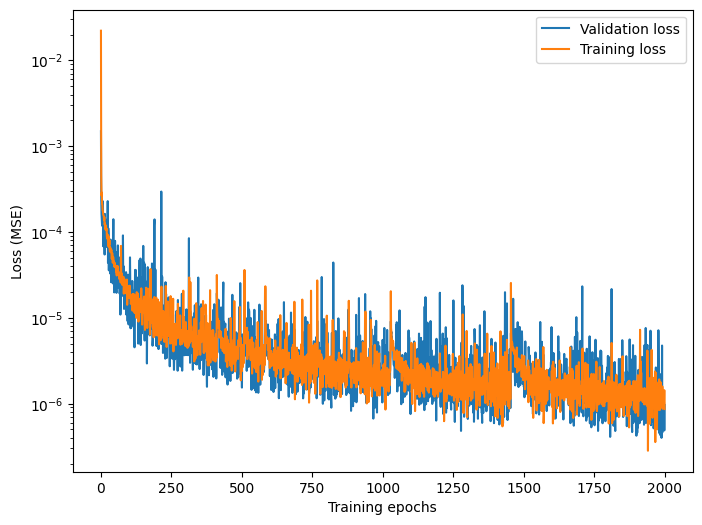

In [43]:
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(8,6))
history.history.keys()
plt.semilogy(history.history['val_loss'])
plt.semilogy(history.history['loss'])
plt.legend(['Validation loss', 'Training loss'])
plt.xlabel('Training epochs')
plt.ylabel('Loss (MSE)')
#plt.savefig(f'./NNresults/Loss/RandomGeneratednoC256x8.jpg', dpi=300)
plt.show()

### Network prediction and validation of results

In [28]:
y_predict = model.predict(x_test)
y_pred = pd.DataFrame(y_predict, columns=y_test.columns)

625/625 [==============================] - 3s 3ms/step


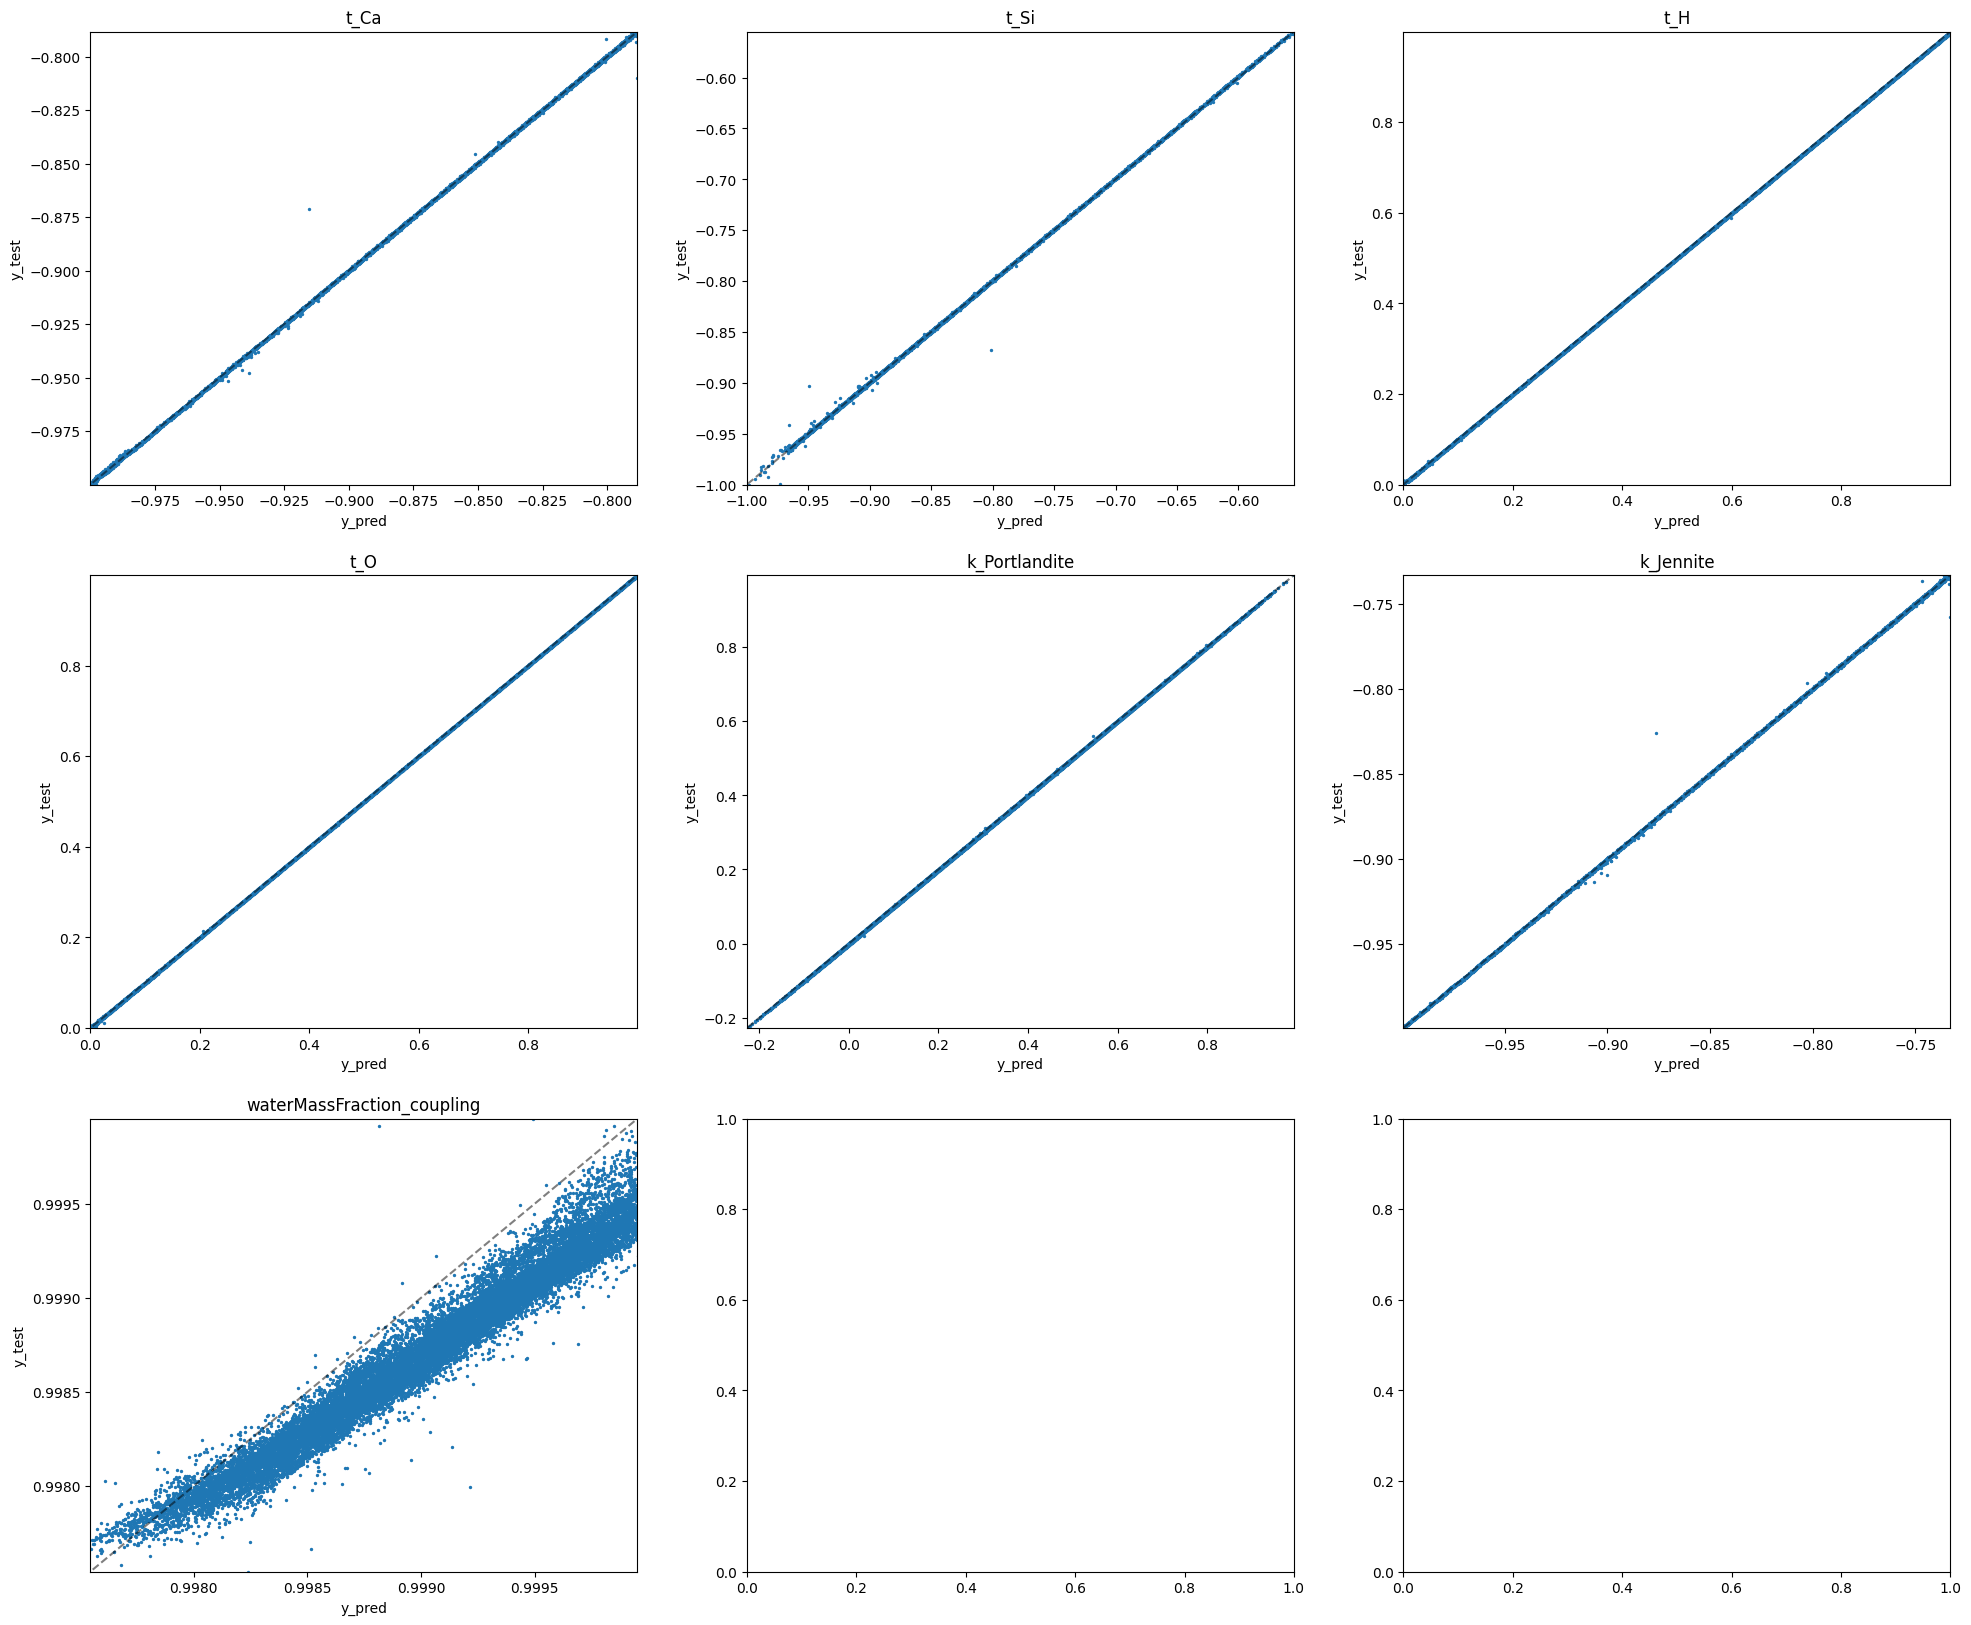

In [30]:
now = '-'.join('_'.join(datetime.now().strftime("%Y-%m-%d %H:%M:%S").split(' ')).split(':'))
r1 = np.linspace(-10,10,100)
fig, ax = plt.subplots(3,3, figsize=(24,20))
i = 0
for axs in ax.flat:
    if i<len(y_test.columns):
        col = y_test.columns[i]
        i+=1
        axs.scatter(y_pred[col], y_test[col], s=2)
        axs.plot(r1,r1,'k--',alpha=0.5)
        lim = [y_test[col].min(),y_test[col].max()]
        axs.set(xlabel='y_pred', ylabel='y_test', xlim=lim, ylim=lim)
        axs.set_title(col)
    else:
        pass
#plt.savefig(f'./NNresults/NNresults_{now}.jpg')

In [31]:
r2_dict = {}
for col in y_pred.columns:
    sum_squares_residuals = sum((y_test[col] - y_pred[col]) ** 2)
    sum_squares = sum((y_test[col] - y_test[col].mean()) ** 2)
    R2 = 1 - sum_squares_residuals / sum_squares
    r2_dict[col] = R2
r2_dict

{'t_Ca': 0.9999520946555736,
 't_Si': 0.9999193924993023,
 't_H': 0.9999842020657764,
 't_O': 0.999996770491476,
 'k_Portlandite': 0.9999597821309301,
 'k_Jennite': 0.9999566150795463,
 'waterMassFraction_coupling': 0.5194099994931243}

Features are rescaled back to their original values.

In [33]:
pred = pd.concat([x_test, y_pred], axis=1)
test = pd.concat([x_test, y_test], axis=1)
train = pd.concat([x_train, y_train], axis=1)

In [35]:
train_reversed = scaler.inverse_transform(train)
train_reversed = pd.DataFrame(train_reversed, columns=['Ca_tr','Si_tr','H_tr','O_tr','Portlandite', 'Jennite', 'waterMassFraction',
    't_Ca','t_Si','t_H','t_O','k_Portlandite', 'k_Jennite', 'waterMassFraction_coupling'])
pred_reversed = scaler.inverse_transform(pred)
pred_reversed = pd.DataFrame(pred_reversed, columns=['Ca_tr','Si_tr','H_tr','O_tr','Portlandite', 'Jennite', 'waterMassFraction',
    't_Ca','t_Si','t_H','t_O','k_Portlandite', 'k_Jennite', 'waterMassFraction_coupling'])
test_reversed = scaler.inverse_transform(test)
test_reversed = pd.DataFrame(test_reversed, columns=['Ca_tr','Si_tr','H_tr','O_tr','Portlandite', 'Jennite', 'waterMassFraction',
    't_Ca','t_Si','t_H','t_O','k_Portlandite', 'k_Jennite', 'waterMassFraction_coupling'])

for col in pred_reversed:
    if '_tr' in col:
        pred_reversed[col] = np.exp(pred_reversed[col]) - 1e-10# - data[col].min())
        test_reversed[col] = np.exp(test_reversed[col]) - 1e-10# - data[col].min())
    elif 't_' in col:
        pred_reversed[col] = np.exp(pred_reversed[col]) - 1e-10# - data[col].min())
        test_reversed[col] = np.exp(test_reversed[col]) - 1e-10# - data[col].min())

<Figure size 1000x1000 with 0 Axes>

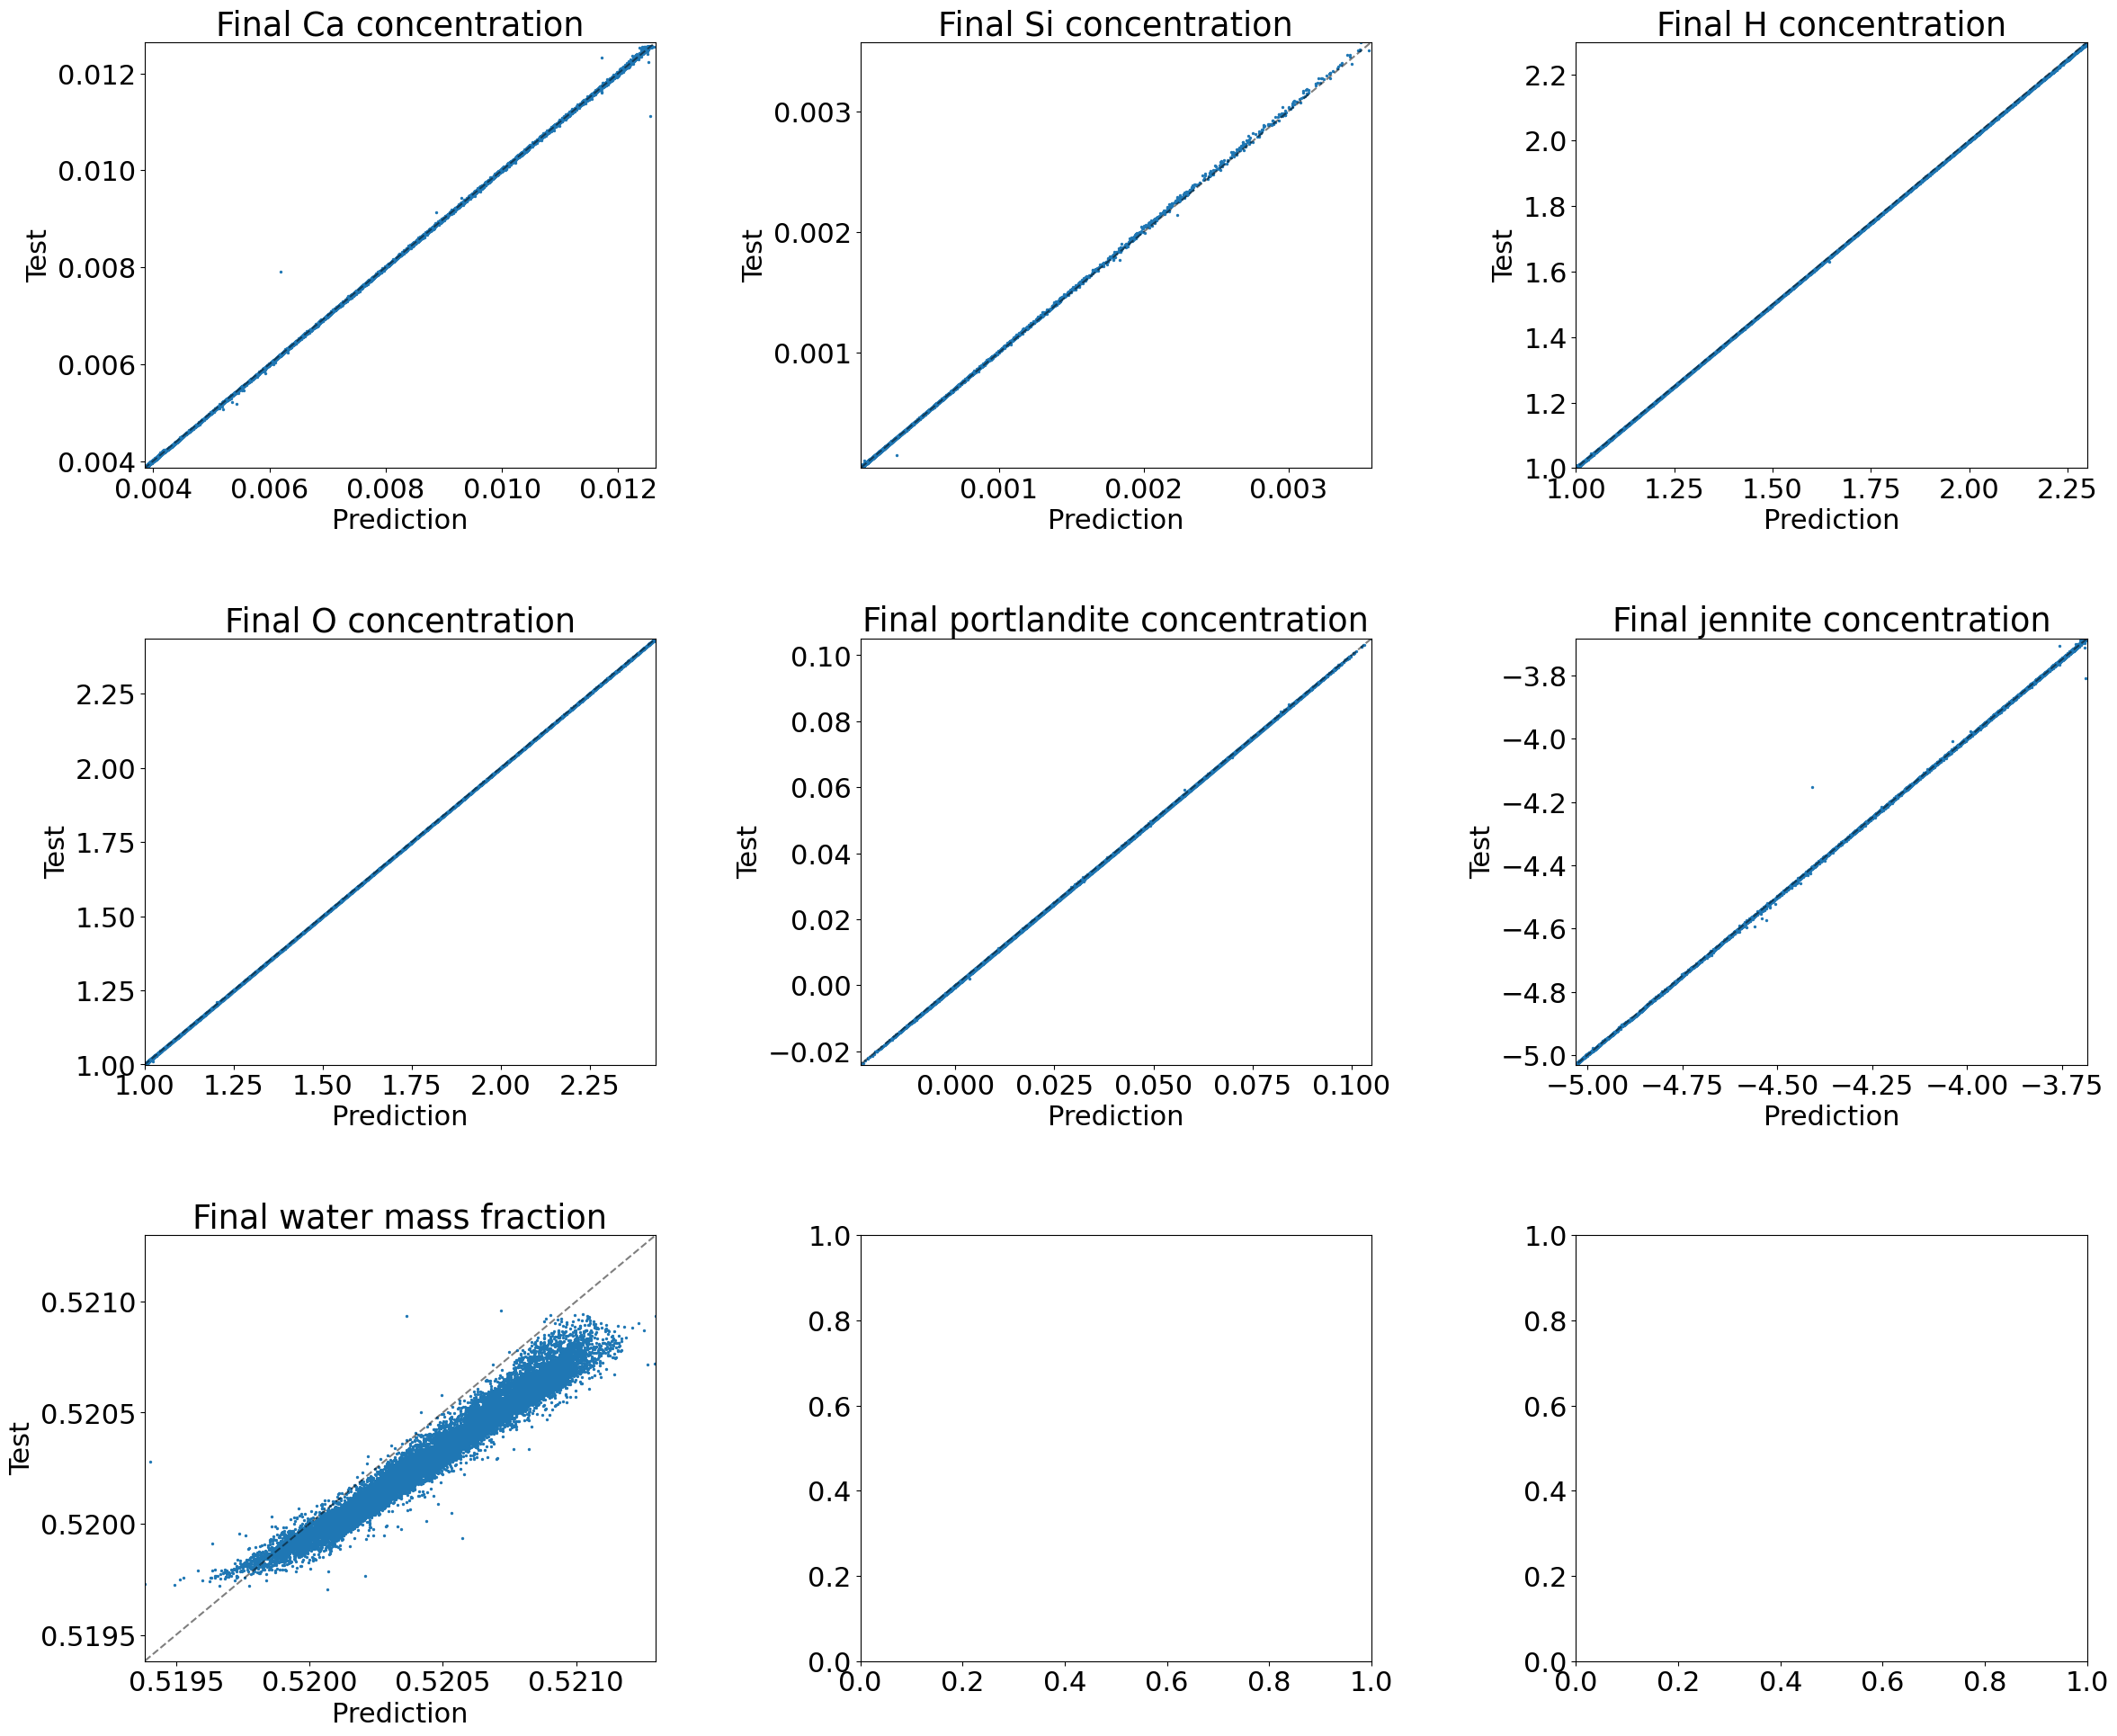

In [40]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 22})
now = '-'.join('_'.join(datetime.now().strftime("%Y-%m-%d %H:%M:%S").split(' ')).split(':'))
r1 = np.linspace(-1000,1000,100)
fig, ax = plt.subplots(3,3, figsize=(24,20))
i = 0
titles = ['Final Ca concentration', 'Final Si concentration', 'Final H concentration', 'Final O concentration',
         'Final portlandite concentration', 'Final jennite concentration', 'Final water mass fraction']
for axs in ax.flat:
    if i<len(y_pred.columns):
        col = y_pred.columns[i]
        i+=1
        axs.scatter(pred_reversed[col], test_reversed[col], s=2)
        axs.plot(r1,r1,'k--',alpha=0.5)
        #lim = [min(pred_reversed[col].min(), test_reversed[col].min()),max(pred_reversed[col].max(), test_reversed[col].max())]
        lim = [pred_reversed[col].min(),pred_reversed[col].max()]
        axs.set(xlabel='Prediction', ylabel='Test', xlim=lim, ylim=lim)
        #axs.xaxis.label.set_size(16)
        #axs.yaxis.label.set_size(16)
        axs.set_title(titles[i-1])
    else:
        pass
    plt.subplots_adjust(left=0.075, right=0.975, 
                        top=0.95, bottom=0.05, 
                        wspace=0.4, hspace=0.4)
#plt.savefig(f'./NNresults/NNresults_RTM_{now}.jpg', dpi=300)

In [37]:
r2_dict_reversed = {}
for col in y_test.columns:
    sum_squares_residuals = sum((test_reversed[col] - pred_reversed[col]) ** 2)
    sum_squares = sum((test_reversed[col] - test_reversed[col].mean()) ** 2)
    R2 = 1 - sum_squares_residuals / sum_squares
    r2_dict_reversed[col] = R2
r2_dict_reversed

{'t_Ca': 0.9999480280536714,
 't_Si': 0.9998417965762132,
 't_H': 0.9999778433989557,
 't_O': 0.9999966517545827,
 'k_Portlandite': 0.9999597821309301,
 'k_Jennite': 0.9999566150795463,
 'waterMassFraction_coupling': 0.5194099994931273}

In [38]:
'''
history_df = pd.DataFrame(history.history)
history_df.to_csv('./result_datasets/random_noC_history.csv')
pred_reversed.to_csv('./result_datasets/random_noC_pred.csv')
test_reversed.to_csv('./result_datasets/random_noC_test.csv')
train_reversed.to_csv('./result_datasets/random_noC_train.csv')
'''

In [44]:
pd.DataFrame(history.history).loc[(pd.DataFrame(history.history)['val_loss'] == pd.DataFrame(history.history)['val_loss'].min()) | 
                                    (pd.DataFrame(history.history)['loss'] == pd.DataFrame(history.history)['loss'].min())]

,loss,mean_squared_error,val_loss,val_mean_squared_error
1940,2.820717e-07,2.820717e-07,1.231800e-06,1.231800e-06
1988,1.019034e-06,1.019034e-06,3.984909e-07,3.984909e-07
